# A minha nota (Competição Kaggle)

Equipa Batatinhas123:

    - João Ferreira - 21905985
    - Paulo Pinto - 21906966

Estrutura projeto
```
├── data
│   └── student_data.csv
│   └── test_data.csv
└── notebook.ipynb
```

## Imports + Helpers

In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

Leitura e Escrita

In [2]:
def write_prediction_to_file(prediction, filename):
    with open(f"data/prediction_{filename}.csv", "w+") as fp:
        fp.write(f"index,G3\n")
        for i, n in enumerate(prediction):
            fp.write(f"{i},{n}\n")

def write_to_best_file(rmse, pred, seed):
    with open(f"data/best.csv", "a") as fp:
        fp.write(f"\n{rmse=} ; {seed=}")

# track last seed used
def manage_seed(counter_value=0):
    """
    write to  file -> manage_seed(1234)
    read from file -> manage_seed()
    """
    if counter_value == 0:
        with open("last_seed.txt") as fp:
            return fp.readline()

    with open("last_seed.txt", "w+") as fp:
        fp.write(str(counter_value))

# reset seed counter
# manage_seed(1)

## Análise dos dados

In [3]:
notas_df = pd.read_csv("data/student_data.csv")
# notas_df = notas_df[notas_df["G3"] != 0] # remove notas 0
notas_df

,index,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1000,15,4,2,1,1,0,3,5,2,...,1,0,0,1,0,1,0,1,1,0
1,1001,18,2,1,2,2,0,4,3,5,...,1,0,0,1,1,0,0,1,0,1
2,1002,17,3,3,2,4,1,5,4,5,...,0,1,0,1,0,1,1,0,1,0
3,1003,16,3,3,1,3,0,4,3,3,...,1,0,0,1,0,1,0,1,0,1
4,1004,17,1,1,2,1,0,4,4,5,...,0,1,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1540,17,4,4,3,1,3,3,3,3,...,0,1,0,1,0,1,0,1,0,1
541,1541,17,1,1,1,3,0,4,3,4,...,0,1,0,1,0,1,1,0,0,1
542,1542,17,1,3,2,1,0,5,1,2,...,0,1,0,1,0,1,1,0,0,1
543,1543,17,1,0,2,2,0,4,4,5,...,1,0,0,1,0,1,0,1,0,1


    - school (GP ≳ 2 que MS) sns.barplot(data=notas_df, x="school", y="grade").set_title("graph")
    - absences -> sns.lineplot(data=notas_df, y="absences",x="grade").set_title("graph")

Text(0.5, 1.0, 'graph')

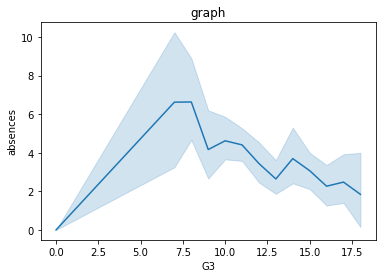

In [4]:
sns.lineplot(data=notas_df, y="absences",x="G3").set_title("graph")

Text(0.5, 1.0, 'graph')

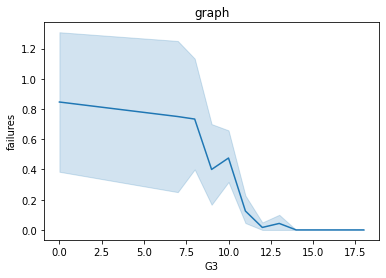

In [5]:
sns.lineplot(data=notas_df, y="failures",x="G3").set_title("graph")

### Analisar correlações

correlations ->

visualize - https://seaborn.pydata.org/tutorial/relational.html

get - https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

get unique - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unstack.html

In [6]:
correlations = notas_df.corr()
upper_corr = correlations.where(np.triu(np.ones(correlations.shape), k = 1).astype(bool))
unique_corr = upper_corr.unstack().dropna()
sorted_corr = unique_corr.sort_values()
g3_corr = abs(sorted_corr["G3"]).sort_values()
g3_corr

index         0.057305
goout         0.078666
famrel        0.086336
health        0.091598
absences      0.097812
freetime      0.109047
age           0.110315
traveltime    0.163644
Walc          0.168310
Dalc          0.179147
Fedu          0.198938
Medu          0.260261
studytime     0.281908
failures      0.382862
dtype: float64

Optámos por remover as variáveis independentes que tinham menos correlação com a variável dependente. Esta remoção diminui o tempo de treino (numa iteração não é significante mas em milhares começa a ser) e melhora as previsões porque as variáveis com mais correlação ficam com mais peso no valor final.

In [7]:
low_correlation_vars = ["goout", "famrel", "health"]

## Leitura dos dados

Testámos remover as rows em que a nota final era 0, mas esta alteração piorou os resultados.

Avaliámos a performance dos modelos criados mediante a divisão dos dados e deduzimos que a melhor percentagem para dados de treino é entre 70% e 80%.

In [8]:
notas_df = pd.read_csv("data/student_data.csv")
# notas_df = notas_df[notas_df["G3"] == 0] # remove notas 0
notas_df = notas_df.drop(low_correlation_vars, axis=1)
notas = notas_df.drop(["G3", "index"], axis=1)

# splitting the data
features_train, features_test, target_train, target_test = \
train_test_split(notas, notas_df['G3'], test_size = 0.2, random_state=0)

0


## Treinar um modelo

Seguindo [o guia de escolha de estimators do sklearn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), vemos que o *estimator* correto é um da categoria EnsebleRegressors. Optámos pelo RandomForestRegressor.

In [9]:
# código para avaliar os diferentes parâmetros do RandomForestRegressor e guardar os melhores resultados.

best = 3.0, 0, 0 # save best so far
iterations = 20

for r in range(iterations):
    rand = randint(999999)
    
    params = {
    'n_estimators': 50,
    'max_features': 0.2,
    'max_depth': 10,
    "random_state" : rand
    }
    
    rf = RandomForestRegressor(**params).fit(features_train, target_train)
    
    prediction = rf.predict(features_test)
    rmse = np.sqrt(mean_squared_error(target_test, prediction))

    # replace best so far
    if rmse < best[0]:
        best = rmse, rand, prediction
        print(f"new best - rmse {best[0]:.3f} {best[1]}")

# save best prediction
write_prediction_to_file(best[2], f"rmse_{best[0]:.3f}_seed_{best[1]}")

print(f"best rmse {best[0]:.3f}, seed {best[1]}")

new best - rmse 2.728 350894
new best - rmse 2.711 734279
new best - rmse 2.706 824186
best rmse 2.706, seed 824186


Deduzimos por análise dos valores RMSE que os melhores valores para os parâmetros foram os seguintes:

| Parâmetro | Melhores Valores | Significado |
| ----------- | ----------- | ----------- |
| n_estimators | entre 45 e 55 | Quantas decision trees são usadas |
| max_features | entre 0.2 e 0.3 | % máx. de *features* analisadas por split |
| max_depth | entre 10 e 13 | Número máximo de níveis da árvore |
| random_state | não tem | Escolher random seed |

## Previsão e Escrita

Prever os valores `test_data.csv` e guardar no ficheiro para submissão. 

In [10]:
test_values = pd.read_csv("data/test_data.csv").drop("index", axis=1).drop(low_correlation_vars, axis=1) 

random_forest_seed = 521759

params = {
    'n_estimators': 50,
    'max_features': 0.2,
    'max_depth': 10,
    "random_state" : random_forest_seed
}

rf = RandomForestRegressor(**params).fit(features_train, target_train)
prediction = rf.predict(features_test)

rmse = np.sqrt(mean_squared_error(target_test, prediction))

print(rmse)

# guardar previsão no ficheiro.csv
prediction_submit = rf.predict(test_values)
write_prediction_to_file(prediction_submit, f"rmse_{rmse:.3f}_forestseed_{random_forest_seed}")

2.655024294643167


Timeline:
- [x] ler dados
- [x] regressão linear 70% dos dados `student_data.csv`
- [x] testar com os restantes 30%
- [x] prever `test_data.csv`
- [x] parameter tuning !!!
- [x] alterações
- [x] submeter 👍

Webgrafia:

https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/

https://datatofish.com/multiple-linear-regression-python/

https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

RandomForestRegressor - https://towardsdatascience.com/random-forest-regression-5f605132d19d